In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [120]:
np.random.seed(42)  # for reproducibility

dates = pd.date_range(start='2025-01-01', end='2025-01-31', freq='D')
weight = [175]  # start weight
for _ in range(1, len(dates)):
    change = np.random.uniform(-3, 3)  # small daily fluctuations
    new_weight = weight[-1] + change
    new_weight = np.clip(new_weight, 165, 185)  # keep within realistic range
    weight.append(round(new_weight, 1))

weight_over_time = pd.DataFrame({
    'Date': dates,
    'Weight_Pounds': weight,
    'Exercise_Minutes': np.random.randint(0, 60, len(dates))
})
weight_over_time.head()

,Date,Weight_Pounds,Exercise_Minutes
0,2025-01-01,175.0,50
1,2025-01-02,174.2,6
2,2025-01-03,176.9,20
3,2025-01-04,178.3,8
4,2025-01-05,178.9,38


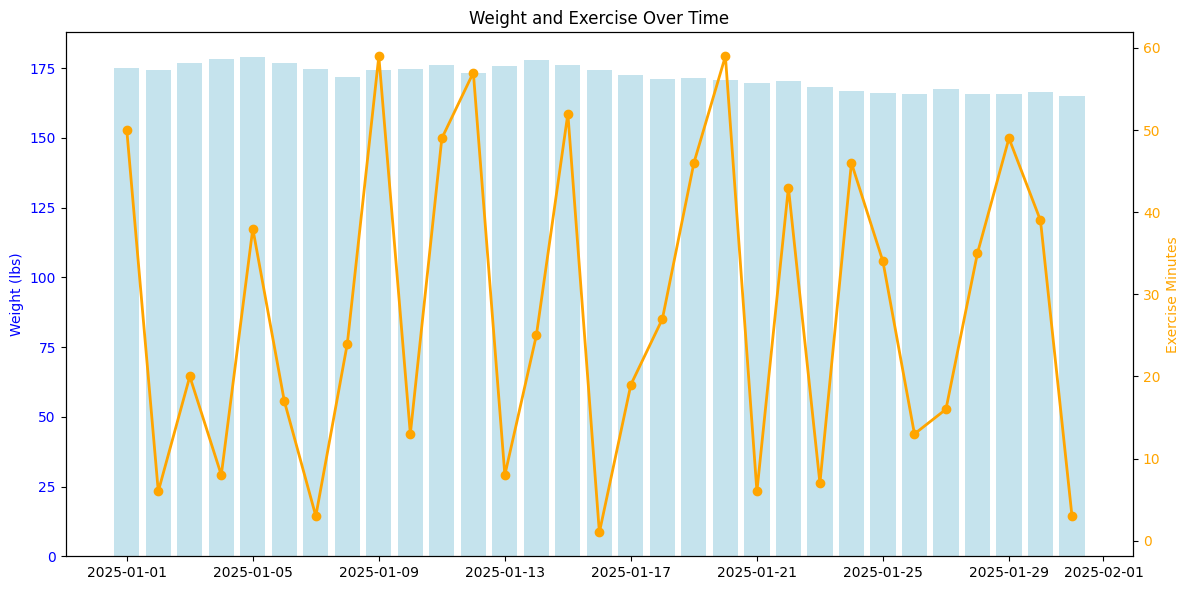

In [121]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(weight_over_time['Date'], weight_over_time['Weight_Pounds'],
        color='lightblue', label='Weight (lbs)', alpha=0.7)
ax1.set_ylabel('Weight (lbs)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(weight_over_time['Date'], weight_over_time['Exercise_Minutes'],
         color='orange', marker='o', label='Exercise Minutes', linewidth=2)
ax2.set_ylabel('Exercise Minutes', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Weight and Exercise Over Time')
fig.tight_layout()
plt.show()

In [122]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)    

def make_multistep_target(ts, steps):
    return pd.concat(
        {
            f'y_future_{i}': ts.shift(-i)
            for i in range(1, steps + 1)
        },
        axis=1)

y = weight_over_time.set_index('Date')['Weight_Pounds']
X = make_lags(y, 5).fillna(0.0)
y = make_multistep_target(y, 3).dropna()

y, X = y.align(X, join='inner', axis=0)


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

r2 = r2_score(y_test, y_pred)

Test RMSE: 25.15


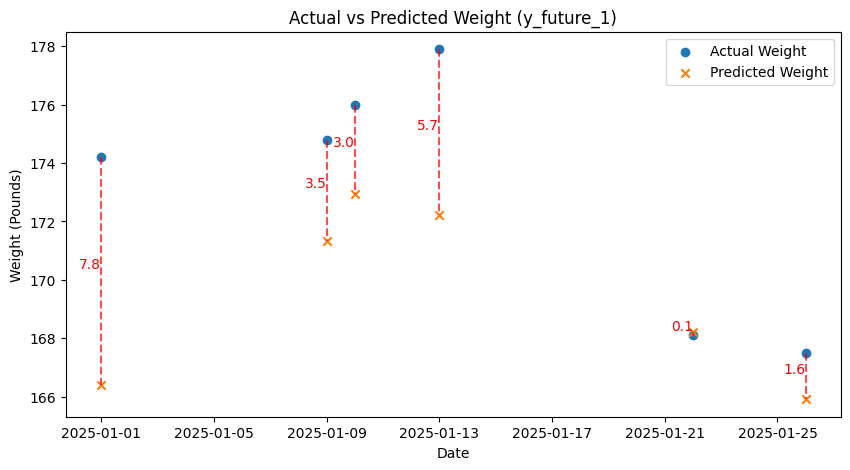

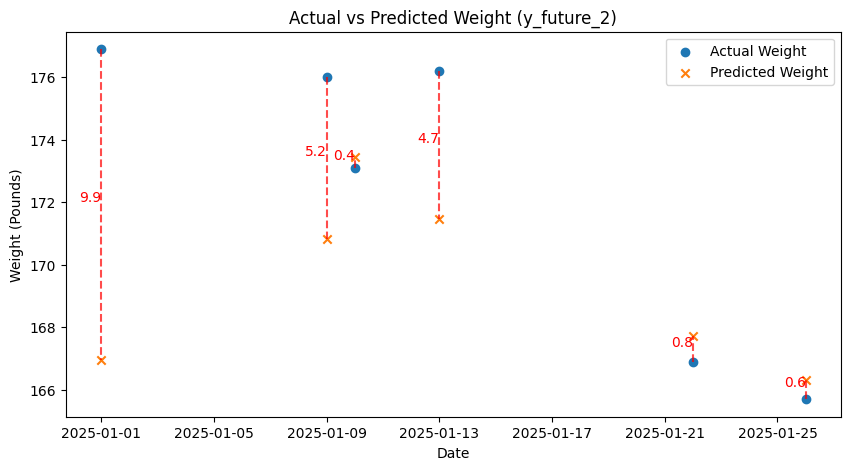

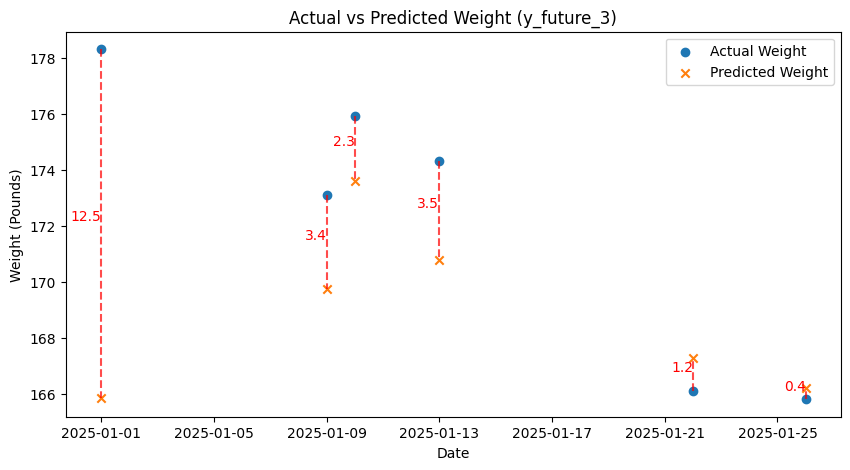

In [124]:
test_rmse = mean_squared_error(y_test, y_pred)
print((f"Test RMSE: {test_rmse:.2f}"))

for col in y_test.columns:
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test.index, y_test[col], label='Actual Weight', marker='o')
    plt.scatter(y_test.index, y_pred[col], label='Predicted Weight', marker='x')
    
    for idx, actual, pred in zip(y_test.index, y_test[col], y_pred[col]):
        plt.plot([idx, idx], [actual, pred], color='red', linestyle='--', alpha=0.7)
        plt.text(idx, (actual + pred) / 2, f"{round(abs(actual - pred), 1):.1f}",
                 color='red', ha='right', va='bottom', fontsize=10)

    plt.title(f'Actual vs Predicted Weight ({col})')
    plt.xlabel('Date')
    plt.ylabel('Weight (Pounds)')
    plt.legend()
    plt.show()

In [125]:
# Assume y_series is your full historical series
y_series = weight_over_time.set_index('Date')['Weight_Pounds']

# Match the lag count used in training
LAGS = 5
last_X = make_lags(y_series, lags=LAGS).iloc[[-1]].dropna()

future_preds = model.predict(last_X)[0]

In [126]:
future_preds

array([165.887, 166.524, 165.549])

In [127]:
future_dates = pd.date_range(
    start=y_series.index.max() + pd.Timedelta(days=1),
    periods=3,
    freq='D'
)

forecast = pd.Series(future_preds, index=future_dates, name='Forecast_Weight')
print(forecast)

2025-02-01    165.887
2025-02-02    166.524
2025-02-03    165.549
Freq: D, Name: Forecast_Weight, dtype: float64


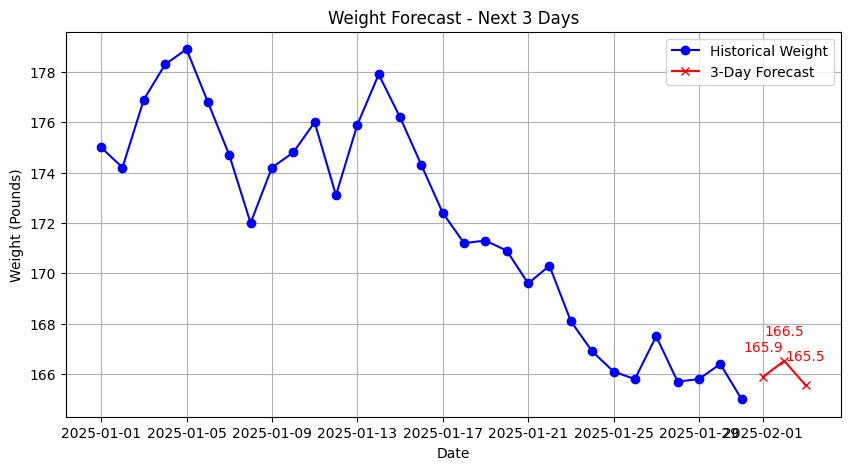

In [128]:
# Combine the original series with the forecast for plotting
combined_series = pd.concat([y_series, forecast])

plt.figure(figsize=(10, 5))

# Plot the historical data
plt.plot(y_series.index, y_series, label='Historical Weight', color='blue', marker='o')

# Plot the forecasted values
plt.plot(forecast.index, forecast, label='3-Day Forecast', color='red', marker='x')

# Highlight forecast points with text
for date, value in forecast.items():
    plt.text(date, value + 1, f"{value:.1f}", color='red', ha='center')

plt.title('Weight Forecast - Next 3 Days')
plt.xlabel('Date')
plt.ylabel('Weight (Pounds)')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
LAGS = 5
days_to_forecast = 7
y_hist = y_series.copy()
recursive_preds = []

while len(recursive_preds) < days_to_forecast:
    # Create the most recent lagged features
    last_X = make_lags(y_hist, lags=LAGS).iloc[[-1]].dropna()
    if last_X.empty:
        raise ValueError("Not enough data to generate lag features.")

    # Predict 3 horizons
    preds = model.predict(last_X)[0]

    # Generate dates for these predictions
    next_dates = pd.date_range(
        start=y_hist.index.max() + pd.Timedelta(days=1),
        periods=3,
        freq='D'
    )

    # Add predictions to history for recursion
    for date, val in zip(next_dates, preds):
        if len(recursive_preds) < days_to_forecast:
            y_hist.loc[date] = val
            recursive_preds.append((date, val))

# Convert results into a Series
week_forecast = pd.Series(dict(recursive_preds))
print(week_forecast)

2025-02-01    165.887
2025-02-02    166.524
2025-02-03    165.549
2025-02-04    165.887
2025-02-05    166.524
2025-02-06    165.549
2025-02-07    165.887
dtype: float64


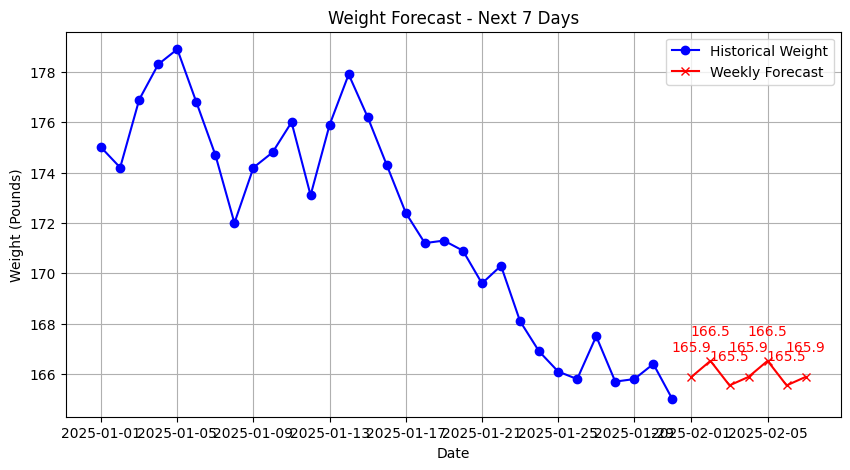

In [135]:
# Combine the original series with the forecast for plotting
combined_series = pd.concat([y_series, week_forecast])

plt.figure(figsize=(10, 5))

# Plot the historical data
plt.plot(y_series.index, y_series, label='Historical Weight', color='blue', marker='o')

# Plot the forecasted values
plt.plot(week_forecast.index, week_forecast, label='Weekly Forecast', color='red', marker='x')

# Highlight forecast points with text
for date, value in week_forecast.items():
    plt.text(date, value + 1, f"{value:.1f}", color='red', ha='center')

plt.title('Weight Forecast - Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Weight (Pounds)')
plt.legend()
plt.grid(True)
plt.show()